In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

***
# 2017 NSCH Data

**Code book:** https://www.census.gov/data-tools/demo/nsch/#/?s_searchvalue=age&s_year=2017&selectedVar=A1_AGE

**Article:** http://time.com/5437607/smartphones-teens-mental-health/


In [2]:
df = pd.read_stata('nsch_2017_topical.dta')
df.head()

,fipsst,stratum,hhid,formtype,totkids_r,hhlanguage,sc_age_years,sc_sex,k2q35a_1_years,momage,...,a1_grade_if,bmiclass,hhcount_if,fpl_i1,fpl_i2,fpl_i3,fpl_i4,fpl_i5,fpl_i6,fwc
0,37,1,17000010,T1,3,3.0,0,2,NaN,36.0,...,0,NaN,0,50,50,50,50,50,50,16407.556854
1,2,2A,17000013,T3,1,1.0,13,2,NaN,30.0,...,0,2.0,0,181,181,181,181,181,181,152.449899
2,40,1,17000025,T3,1,1.0,15,1,13.0,30.0,...,0,2.0,0,329,329,329,329,329,329,605.780083
3,13,1,17000031,T2,1,1.0,9,1,NaN,27.0,...,0,NaN,0,347,347,347,347,347,347,1793.169449
4,31,1,17000034,T2,2,1.0,8,2,NaN,27.0,...,0,NaN,0,400,400,400,400,400,400,688.982814


## Data Processing

`sc_age_years`: Age of Selected Child - In Years (0 - 17)

In [3]:
df.sc_age_years.describe()

count    21599.000000
mean         9.428585
std          5.260100
min          0.000000
25%          5.000000
50%         10.000000
75%         14.000000
max         17.000000
Name: sc_age_years, dtype: float64

***

`k7q91_r`: How Much Time Spent with Computers

`k7q60_r`: How Much Time Spent Watching TV

**Response Codes:**
- 1 = None
- 2 = Less than 1 hour
- 3 = 1 hour
- 4 = 2 hours
- 5 = 3 hours
- 6 = 4 or more hours

In [119]:
df['cmputr_time'] = df.k7q91_r.copy() - 1
df.cmputr_time.describe()

count    21402.000000
mean         2.279507
std          1.555088
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: cmputr_time, dtype: float64

In [120]:
df['tv_time'] = df.k7q60_r.copy() - 1
df.tv_time.describe()

count    21399.000000
mean         2.314547
std          1.321909
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: tv_time, dtype: float64

***
`k4q22_r`: DURING THE PAST 12 MONTHS, has (fill with SC_NAME) received any treatment or counseling from a mental health professional...Mental health professionals include psychiatrists, psychologists, psychiatric nurses, and clinical social workers.

**Response Code:**
- 1 = Yes
- 2 = No, but this child needed to see a mental health professional
- 3 = No, this child did not need to see a mental health professional

In [6]:
df['need_treatment'] = df.k4q22_r.dropna().copy()
df.need_treatment.describe()

count    21504.000000
mean         2.773484
std          0.619546
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: need_treatment, dtype: float64

***
`k2q33a`: Has a doctor or other health care provider EVER told you that (fill with SC_NAME) has...Anxiety Problems? **Yes=1**, **No=2** or **NaN**

`k2q33b`: If yes, does (fill with SC_NAME) CURRENTLY have the condition? **Yes=1**, **No=2** or **NaN**

`k2q33c`: Anxiety Severity Level.

**Response Code:**
- 1 = Mild
- 2 = Moderate
- 3 = Severe

**Create a column indicating Anxiety Severity Level:**

**Response Code:**
- NaN = Did not provide answers to any of these questions
- 0 = Did not have anxiety (`k2q33a` is No or `k2q33b` is No)
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [301]:
# Cleaning data to make sure NaN will not mess up with 0
anxiety_lvl = df.k2q33c.copy()
for i in range(len(df['anxiety_lvl'])):
    if df['k2q33a'][i] == 2 or df['k2q33b'][i] == 2:
        if np.isnan(anxiety_lvl[i]):
            anxiety_lvl[i] = 0
df['anxiety_lvl'] = anxiety_lvl
df['anxiety_lvl'].describe()

count    21479.000000
mean         0.132269
std          0.480712
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: anxiety_lvl, dtype: float64

***
`k2q32a`: Has a doctor or other health care provider EVER told you that (fill with SC_NAME) has...Depression Problems? **Yes=1**, **No=2** or **NaN**

`k2q32b`: If yes, does (fill with SC_NAME) CURRENTLY have the condition? **Yes=1**, **No=2** or **NaN**

`k2q32c`: Depression Severity Level.

**Response Code:**
- 1 = Mild
- 2 = Moderate
- 3 = Severe

**Create a column indicating Depression Severity Level:**

**Response Code:**
- NaN = Did not provide answers to any of these questions
- 0 = Did not have depression (`k2q32a` is No or `k2q32b` is No)
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [302]:
# Cleaning data to make sure NaN will not mess up with 0
depression_lvl = df.k2q32c.copy()
for i in range(len(df['depression_lvl'])):
    if df['k2q32a'][i] == 2 or df['k2q32b'][i] == 2:
        if np.isnan(depression_lvl[i]):
            depression_lvl[i] = 0
df['depression_lvl'] = depression_lvl
df['depression_lvl'].describe()

count    21520.000000
mean         0.056691
std          0.317323
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: depression_lvl, dtype: float64

***
`k8q11`: DURING THE PAST WEEK, on how many days did all the family members who live in the household eat a meal together?

**Response Code:**
- 1 = 0 days
- 2 = 1-3 days
- 3 = 4-6 days
- 4 = Every day

In [10]:
df['family_meals'] = df.k8q11.dropna().copy() - 1
df.family_meals.describe()

count    21278.000000
mean         2.065232
std          0.866397
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: family_meals, dtype: float64

***
`k7q83_r`: How well do each of the following phrases describe: Your child does all required homework

**Response Code:**
- 1 = Definitely true
- 2 = Somewhat true
- 3 = Not true

In [9]:
df['homework_completion'] = df.k7q83_r.dropna().copy()
df.homework_completion.describe()

count    15238.000000
mean         1.305027
std          0.550181
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: homework_completion, dtype: float64

***
## Experiments with these variables

### Plot age vs Screen time
Variables used: `sc_age_years`, `cmputr_time`, `tv_time`

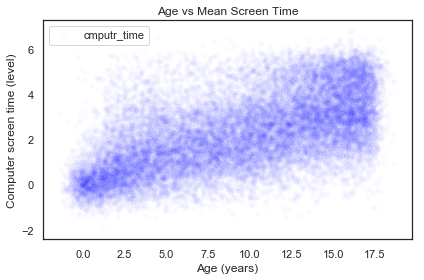

In [11]:
# Jitter plot
x = thinkstats2.Jitter(df.sc_age_years, 0.5)
y1 = thinkstats2.Jitter(df.cmputr_time, 0.5)
thinkplot.Scatter(x, y1, alpha=0.02)
plt.legend(loc='best')
decorate(title='Age vs Mean Screen Time', xlabel='Age (years)', ylabel='Computer screen time (level)')

In [12]:
# Group them into age year bins
bins = np.arange(df.sc_age_years.min(), df.sc_age_years.max() + 1, 1)
indices = np.digitize(df.sc_age_years, bins)
groups = df.groupby(indices)

cmputr_time = [group.cmputr_time.mean() for i, group in groups]
tv_time = [group.tv_time.mean() for i, group in groups]

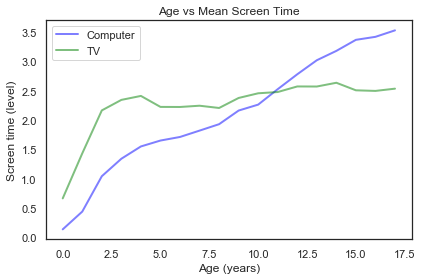

In [13]:
plt.plot(bins, cmputr_time, label='Computer', linewidth=2, color='blue', alpha=0.5)
plt.plot(bins, tv_time, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Age vs Mean Screen Time', xlabel='Age (years)', ylabel='Screen time (level)')

***
### Screen time vs Need treament
Variables used: `cmputr_time`, `tv_time`, `need_treatment`

In [250]:
# Group them into bins
def group_to_bins(df, group_name, variable):
    dataSeries = df[group_name]
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
    indices = np.digitize(dataSeries, bins)
    groups = df.groupby(indices)

    perc_1 = []
    perc_2 = []
    for i, group in groups:
        count = count_2 = 0
        total = group[variable].count()
        for value in group[variable]:
            if (value == 1):
                count += 1
            if (value == 2):
                count_2 += 1
        perc_1.append(count/total*100)
        perc_2.append((count + count_2)/total*100)
    return bins, np.array(perc_1), np.array(perc_2)

bins, perc_1, perc_2 = group_to_bins(df, 'cmputr_time', 'need_treatment')
bins_tv, perc_1_tv, perc_2_tv = group_to_bins(df, 'tv_time', 'need_treatment')

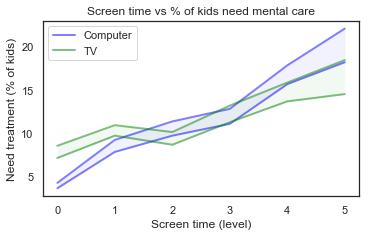

In [251]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc_1, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.plot(bins, perc_2, linewidth=2, color='blue', alpha=0.5)
ax.fill_between(bins, perc_1, perc_2, where=perc_2 >= perc_1, facecolor='blue', alpha=0.05, interpolate=True)
# TV time
ax.plot(bins_tv, perc_1_tv, label='TV', linewidth=2, color='green', alpha=0.5)
ax.plot(bins_tv, perc_2_tv, linewidth=2, color='green', alpha=0.5)
ax.fill_between(bins_tv, perc_1_tv, perc_2_tv, where=perc_2_tv >= perc_1_tv, facecolor='green', alpha=0.05, interpolate=True)
plt.legend(loc='best')
decorate(title='Screen time vs % of kids need mental care', xlabel='Screen time (level)', ylabel='Need treatment (% of kids)')

***
### Screen time vs Anxiety/Depression level
Variables used: `cmputr_time`, `tv_time`, `anxiety_lvl`, `depression_lvl`

In [333]:
# Group them into bins
def GroupToBins(df, group_name='cmputr_time', bin_size=1):
    dataSeries = df[group_name]
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, bin_size)
    indices = np.digitize(dataSeries, bins)
    return np.array(bins), df.groupby(indices)

# Operation: calculate percentage in each group
def CalculatePercentages(groupResults, variable='depression_lvl'):
    bins, groups = groupResults
    perc = [] # Percentage
    for i, group in groups:
        total = group[variable].count()
        positives = group[variable][group[variable] > 0].count() # Having anxiety/depression
        perc.append(positives/total * 100)
    return np.array(bins), np.array(perc)

In [334]:
def SamplingDistributions(df, group_name='cmputr_time', variable='depression_lvl', Operation=CalculatePercentages, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(df)
        _, estimates = Operation(GroupToBins(sample, group_name), variable)
        t.append(estimates)
    return np.array(t).transpose()

In [335]:
def ComputeCIs(estimates):
    cis = []
    for estimate in estimates:
        cdf = thinkstats2.Cdf(estimate)
        ci = cdf.ConfidenceInterval(90)
        cis.append(ci)
    return np.array(cis).transpose()

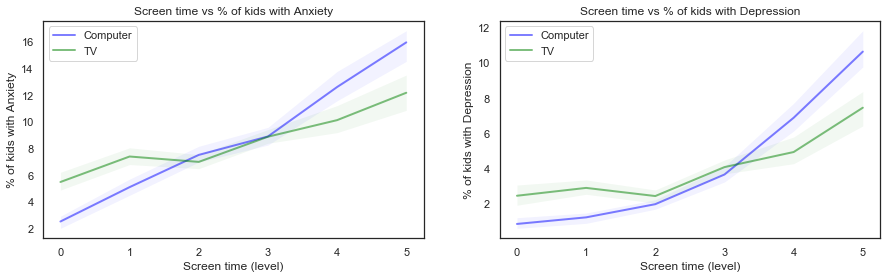

In [444]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety', 'Depression']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculatePercentages(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculatePercentages(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculatePercentages, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculatePercentages, variable=variables[i]))
    # Computer time
    ax[i].plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
    ax[i].fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
    # TV time
    ax[i].plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
    ax[i].fill_between(bins, cis_tv[0], cis_tv[1], where=cis_tv[0] <= cis_tv[1], 
                    facecolor='green', alpha=0.05, interpolate=True)
    ax[i].legend(loc='best')
    ax[i].title.set_text("Screen time vs % of kids with " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel='% of kids with ' + labels[i])

**Calculate P values**

In [442]:
groupResults = GroupToBins(df, group_name='cmputr_time', bin_size=3)
bins, perc = CalculatePercentages(groupResults, variable='depression_lvl')
perc[1]/perc[0] # Proportional percentage of depression (High / Low) 

4.482404584088265

In [443]:
groupResults = GroupToBins(df, group_name='cmputr_time', bin_size=3)
bins, perc = CalculatePercentages(groupResults, variable='anxiety_lvl')
perc[1]/perc[0] # Proportional percentage of anxiety (High / Low) 

2.20260816675434

Assuming that computer time does not have any effect on depression/anxiety level.

In [437]:
class ProportionalTest():
    def __init__(self, data, group_name='cmputr_time', variable='depression_lvl'):
        self.data = df.dropna(subset=[group_name, variable])
        self.group_name = group_name
        self.variable = variable
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

#     Seems like Chi-squared cannot be applied in this case
#     def TestStatistic(self, data):
#         groupResults = GroupToBins(data, group_name='cmputr_time', bin_size=3)

#         # observed percentage in each group
#         _, observed = CalculatePercentages(groupResults, variable='depression_lvl')

#         # expected percentage in each group
#         total = positives = 0
#         bins, groups = groupResults
#         for i, group in groups:
#             total += group['depression_lvl'].count()
#             positives += group['depression_lvl'][group['depression_lvl'] > 0].count() # Having anxiety/depression
#         expected = positives/total * 100

#         test_stat = sum((observed - expected)**2 / expected)
#         return test_stat
        
    def TestStatistic(self, data):
        # observed percentage in each group
        groupResults = GroupToBins(data, self.group_name, bin_size=3)
        _, perc = CalculatePercentages(groupResults, self.variable)
        return perc[1]/perc[0]

    def RunModel(self):
        shuffled_data = self.data.copy()
        shuffled_column = np.random.permutation(shuffled_data.depression_lvl) 
        shuffled_data[self.variable] = shuffled_column
        return shuffled_data

In [440]:
p_test = ProportionalTest(df, group_name='cmputr_time', variable='depression_lvl')
p_test.PValue()

0.0

In [441]:
p_test = ProportionalTest(df, group_name='cmputr_time', variable='anxiety_lvl')
p_test.PValue()

0.0

**Gauging the anxiety/depression level**

In [307]:
# Operation: calculate mean in each group
def CalculateMeans(groups, variable='depression_lvl'):
    means = [] # Mean score of anxiety/depression level
    for i, group in groups:
        means.append(group[variable][group[variable] > 0].mean())
    return np.array(bins), np.array(means)

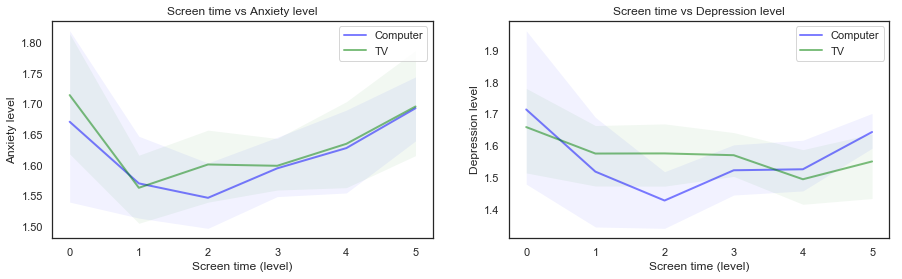

In [306]:
variables = ['anxiety_lvl', 'depression_lvl']
labels = ['Anxiety level', 'Depression level']
fig, ax = plt.subplots(1, 2, figsize=(15,4))

for i in range(len(labels)):
    bins, perc = CalculateMeans(GroupToBins(df, group_name='cmputr_time'), variable=variables[i])
    bins_tv, perc_tv = CalculateMeans(GroupToBins(df, group_name='tv_time'), variable=variables[i])
    cis = ComputeCIs(SamplingDistributions(df, group_name='cmputr_time', Operation=CalculateMeans, variable=variables[i]))
    cis_tv = ComputeCIs(SamplingDistributions(df, group_name='tv_time', Operation=CalculateMeans, variable=variables[i]))
    # Computer time
    ax[i].plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
    ax[i].fill_between(bins, cis[0], cis[1], where=cis[0] <= cis[1], 
                    facecolor='blue', alpha=0.05, interpolate=True)
    # TV time
    ax[i].plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
    ax[i].fill_between(bins, cis_tv[0], cis_tv[1], where=cis_tv[0] <= cis_tv[1], 
                    facecolor='green', alpha=0.05, interpolate=True)
    ax[i].legend(loc='best')
    ax[i].title.set_text("Screen time vs " + labels[i])
    ax[i].set(xlabel='Screen time (level)', ylabel=labels[i])

In [274]:
df[df['anxiety_lvl'] > 0].groupby('cmputr_time')['anxiety_lvl'].describe()

,count,mean,std,min,25%,50%,75%,max
cmputr_time,,,,,,,,
0.0,82.0,1.670732,0.703692,1.0,1.0,2.0,2.0,3.0
1.0,214.0,1.570093,0.629660,1.0,1.0,1.0,2.0,3.0
2.0,344.0,1.546512,0.646263,1.0,1.0,1.0,2.0,3.0
3.0,412.0,1.594660,0.645607,1.0,1.0,2.0,2.0,3.0
4.0,274.0,1.627737,0.634852,1.0,1.0,2.0,2.0,3.0
5.0,422.0,1.701422,0.675986,1.0,1.0,2.0,2.0,3.0


***
### Family meals vs Anxiety/Depression level
Variables used: `family_meals`, `anxiety_lvl`, `depression_lvl`

In [449]:
def group_to_bins(df, group_name, variable):
    dataSeries = df[group_name]
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
    indices = np.digitize(dataSeries, bins)
    groups = df.groupby(indices)

    perc = []
    screen_times = []
    for i, group in groups:
        total = group[variable].count()
        positives = group[variable][group[variable] > 0].count()
        perc.append(positives/total)
        screen_times.append(group['cmputr_time'].mean())
    return bins, np.array(perc), np.array(screen_times)

# Group them into age year bins
bins, perc, screen_time = group_to_bins(df, 'family_meals', 'anxiety_lvl')
bins_depress, perc_depress, screen_time_depress = group_to_bins(df, 'family_meals', 'depression_lvl')

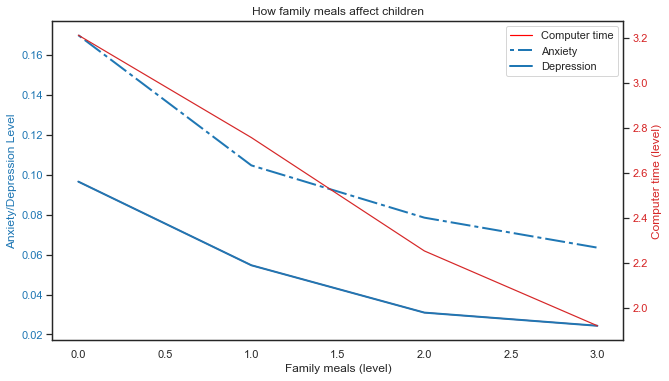

In [450]:
fig, ax2 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax2.set_xlabel('Family meals (level)')
ax2.set_ylabel('Anxiety/Depression Level', color=color)  # we already handled the x-label with ax1
ax2.plot(bins, perc_depress, label='Computer time', linewidth=1.2, color='red', alpha=1) # Cheating a bit. Creating legend for computer time
line, = ax2.plot(bins, perc, label='Anxiety', linewidth=2, color=color)
line.set_dashes([2, 2, 10, 2])
ax2.plot(bins, perc_depress, label='Depression', linewidth=2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax1.set_ylabel('Computer time (level)', color=color)
ax1.plot(bins, screen_time, label='Computer time', linewidth=1.2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('How family meals affect children')

ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

***
### Screen time vs Homework completion
Variables used: `cmputr_time`, `tv_time`, `homework_completion`

In [29]:
# Group them into bins
bins, perc, screen_time_tv = group_to_bins(df, 'cmputr_time', 'homework_completion')
bins_tv, perc_tv, screen_time_tv = group_to_bins(df, 'tv_time', 'homework_completion')

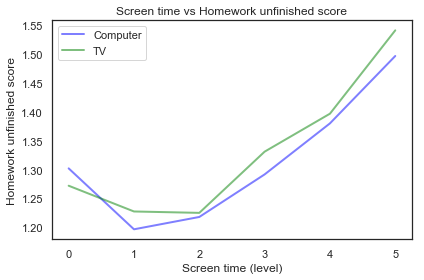

In [30]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
# TV time
ax.plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Screen time vs Homework unfinished score', xlabel='Screen time (level)', ylabel='Homework unfinished score')